In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from pathlib import Path

from __future__ import annotations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np


# Set up plotting with CMS style
plt.style.use(hep.style.CMS)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

print("Imports successful!")

Imports successful!


In [4]:
# Configuration
CARDS_BASE_DIR = "/home/users/lumori/bbtautau/src/bbtautau/cards/25July31/nobbttpresel_noNormSig_noBkgConstraint_ParT"
CHANNELS = ["combined", "hh", "he", "hm"]


# Find all card directories with outputs
def find_output_directories():
    """Find all directories containing analysis outputs"""
    output_dirs = []

    for root, dirs, files in os.walk(CARDS_BASE_DIR):
        if "outs" in dirs:
            outs_path = Path(root) / "outs"
            if any(outs_path.glob("*.txt")):
                output_dirs.append(root)

    return sorted(output_dirs)


output_dirs = find_output_directories()
print(f"Found {len(output_dirs)} directories with outputs:")
for d in output_dirs:
    print(f"  - {Path(d).relative_to(CARDS_BASE_DIR)}")

Found 3 directories with outputs:
  - bmin_1
  - bmin_5
  - bmin_8


In [5]:
def parse_asymptotic_limits(file_path):
    """Parse asymptotic limits from log file"""
    results = {}

    if not Path(file_path).exists():
        return results

    try:
        with open(file_path, "r") as f:
            content = f.read()

        # Look for expected limits pattern
        patterns = {
            "expected_2.5": r"Expected\s+2\.5%:\s*r\s*<\s*([0-9.]+)",
            "expected_16.0": r"Expected\s+16\.0%:\s*r\s*<\s*([0-9.]+)",
            "expected_50.0": r"Expected\s+50\.0%:\s*r\s*<\s*([0-9.]+)",
            "expected_84.0": r"Expected\s+84\.0%:\s*r\s*<\s*([0-9.]+)",
            "expected_97.5": r"Expected\s+97\.5%:\s*r\s*<\s*([0-9.]+)",
            "observed": r"Observed\s+Limit:\s*r\s*<\s*([0-9.]+)",
        }

        for key, pattern in patterns.items():
            match = re.search(pattern, content, re.IGNORECASE)
            if match:
                results[key] = float(match.group(1))

        # Check for convergence issues
        convergence_issues = []
        if "Minimization did NOT converge" in content:
            convergence_issues.append("did_not_converge")

        results["convergence_issues"] = convergence_issues
        results["status"] = "success" if not convergence_issues else "issues"

    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        results["status"] = "parse_error"

    return results


def parse_background_fit(file_path):
    """Parse background fit results"""
    results = {}

    if not Path(file_path).exists():
        return results

    try:
        with open(file_path, "r") as f:
            content = f.read()

        # Check fit status
        if "Minimization success!" in content:
            results["fit_converged"] = True
        elif "Minimization did NOT converge" in content:
            results["fit_converged"] = False
        else:
            results["fit_converged"] = None

        # Extract fit statistics
        nll_match = re.search(r"best fit NLL\s*=\s*([0-9.-]+)", content)
        if nll_match:
            results["best_fit_nll"] = float(nll_match.group(1))

        # Count function calls
        fcn_calls = len(re.findall(r"FCN", content))
        results["function_calls"] = fcn_calls

        # Check for specific issues
        issues = []
        if "Hesse matrix not pos-def" in content:
            issues.append("hesse_not_posdef")
        if "MIGRAD FAILS" in content:
            issues.append("migrad_failed")
        if "Covariance matrix" in content and "not available" in content:
            issues.append("no_covariance")

        results["fit_issues"] = issues

    except Exception as e:
        print(f"Error parsing background fit {file_path}: {e}")

    return results


# Test parsing on first directory
if output_dirs:
    test_dir = Path(output_dirs[0]) / "outs"
    print(f"Testing parsing on: {test_dir}")

    # Look for limit files
    limit_files = list(test_dir.glob("*AsymptoticLimits.txt"))
    if limit_files:
        test_results = parse_asymptotic_limits(limit_files[0])
        print(f"Sample limit parsing: {test_results}")

    # Look for background fit files
    bfit_files = list(test_dir.glob("*MultiDimFit.txt"))
    if bfit_files:
        test_bfit = parse_background_fit(bfit_files[0])
        print(f"Sample background fit parsing: {test_bfit}")

Testing parsing on: /home/users/lumori/bbtautau/src/bbtautau/cards/25July31/nobbttpresel_noNormSig_noBkgConstraint_ParT/bmin_1/outs
Sample limit parsing: {'expected_2.5': 13.2086, 'expected_16.0': 17.4364, 'expected_50.0': 25.2344, 'expected_84.0': 38.0087, 'expected_97.5': 56.3125, 'convergence_issues': [], 'status': 'success'}
Sample background fit parsing: {'fit_converged': True, 'function_calls': 12, 'fit_issues': []}


In [6]:
def collect_all_results():
    """Collect results from all output directories"""
    all_results = []

    for card_dir in output_dirs:
        outs_dir = Path(card_dir) / "outs"
        card_name = Path(card_dir).relative_to(CARDS_BASE_DIR)

        print(f"Processing: {card_name}")

        # Check for different channel results
        for channel in CHANNELS:
            result_entry = {"card_directory": str(card_name), "channel": channel}

            # Look for limits file
            if channel == "combined":
                limit_file = outs_dir / "AsymptoticLimits.txt"
                bfit_file = outs_dir / "MultiDimFit.txt"
            else:
                limit_file = outs_dir / f"{channel}AsymptoticLimits.txt"
                bfit_file = outs_dir / f"{channel}MultiDimFit.txt"

            # Parse limits
            limit_results = parse_asymptotic_limits(limit_file)
            result_entry.update(limit_results)

            # Parse background fit
            bfit_results = parse_background_fit(bfit_file)
            result_entry.update(bfit_results)

            # Only add if we found some results
            if limit_results or bfit_results:
                all_results.append(result_entry)

    return pd.DataFrame(all_results)


# Collect all results
results_df = collect_all_results()
print(f"\nCollected results from {len(results_df)} analyses")
print(f"Columns: {list(results_df.columns)}")
print(f"\nFirst few entries:")
display(results_df.head())

Processing: bmin_1
Processing: bmin_5
Processing: bmin_8

Collected results from 12 analyses
Columns: ['card_directory', 'channel', 'expected_2.5', 'expected_16.0', 'expected_50.0', 'expected_84.0', 'expected_97.5', 'convergence_issues', 'status', 'fit_converged', 'function_calls', 'fit_issues']

First few entries:


,card_directory,channel,expected_2.5,expected_16.0,expected_50.0,expected_84.0,expected_97.5,convergence_issues,status,fit_converged,function_calls,fit_issues
0,bmin_1,combined,13.2086,17.4364,25.2344,38.0087,56.3125,[],success,True,12,[]
1,bmin_1,hh,17.3950,25.1818,39.0625,62.7296,96.8874,[],success,True,8,[]
2,bmin_1,he,35.8594,53.1354,85.0000,140.5654,222.5477,[],success,True,8,[]
3,bmin_1,hm,20.3149,30.4215,49.0625,82.3086,131.9485,[],success,True,11,[]
4,bmin_5,combined,10.9973,14.8714,21.3281,31.4449,44.8875,[],success,True,9,[]


In [7]:
# Summary statistics
print("=== ANALYSIS SUMMARY ===")
print(f"Total analyses: {len(results_df)}")
print(f"Card directories: {results_df['card_directory'].nunique()}")
print(f"Channels analyzed: {sorted(results_df['channel'].unique())}")

# Status summary
if "status" in results_df.columns:
    print("\n=== LIMIT CALCULATION STATUS ===")
    status_counts = results_df["status"].value_counts()
    for status, count in status_counts.items():
        print(f"{status}: {count}")

# Convergence summary
if "fit_converged" in results_df.columns:
    print("\n=== BACKGROUND FIT CONVERGENCE ===")
    conv_counts = results_df["fit_converged"].value_counts()
    for conv, count in conv_counts.items():
        print(f"{conv}: {count}")

# Expected limits summary
if "expected_50.0" in results_df.columns:
    limits_summary = results_df.groupby("channel")["expected_50.0"].agg(
        ["count", "mean", "std", "min", "max"]
    )
    print("\n=== EXPECTED LIMITS (50%) BY CHANNEL ===")
    display(limits_summary.round(3))

=== ANALYSIS SUMMARY ===
Total analyses: 12
Card directories: 3
Channels analyzed: ['combined', 'he', 'hh', 'hm']

=== LIMIT CALCULATION STATUS ===
success: 12

=== BACKGROUND FIT CONVERGENCE ===
True: 12

=== EXPECTED LIMITS (50%) BY CHANNEL ===


,count,mean,std,min,max
channel,,,,,
combined,3,22.578,2.302,21.172,25.234
he,3,85.625,5.962,80.000,91.875
hh,3,29.896,7.939,25.312,39.062
hm,3,46.979,1.831,45.625,49.062


In [8]:
# Create separate transposed tables for each channel
print("=== DETAILED RESULTS BY CHANNEL ===")

# Get available columns
limit_cols = ["expected_2.5", "expected_16.0", "expected_50.0", "expected_84.0", "expected_97.5"]
available_limit_cols = [col for col in limit_cols if col in results_df.columns]

status_cols = ["status", "fit_converged"]
available_status_cols = [col for col in status_cols if col in results_df.columns]

# Create table for each channel
channels = sorted(results_df["channel"].unique())

for channel in channels:
    channel_data = results_df[results_df["channel"] == channel].copy()

    if len(channel_data) > 0:
        # Select columns for this channel (excluding 'channel' since it's the same for all rows)
        summary_cols = ["card_directory"] + available_limit_cols + available_status_cols
        summary_table = channel_data[summary_cols].copy()

        # Format the table
        for col in available_limit_cols:
            if col in summary_table.columns:
                summary_table[col] = summary_table[col].round(3)

        # Transpose the table: set card_directory as index, then transpose
        transposed_table = summary_table.set_index("card_directory").T

        # Apply styling to highlight the expected_50.0 row
        def highlight_expected_50(s):
            return [
                "background-color: #ffeb3b; font-weight: bold" if s.name == "expected_50.0" else ""
                for _ in s
            ]

        styled_table = transposed_table.style.apply(highlight_expected_50, axis=1)

        print(f"\n=== {channel.upper()} CHANNEL ===")
        display(styled_table)

=== DETAILED RESULTS BY CHANNEL ===

=== COMBINED CHANNEL ===


card_directory,bmin_1,bmin_5,bmin_8
expected_2.5,13.209000,10.997000,10.751000
expected_16.0,17.436000,14.871000,14.659000
expected_50.0,25.234000,21.328000,21.172000
expected_84.0,38.009000,31.445000,31.130000
expected_97.5,56.312000,44.888000,44.248000
status,success,success,success
fit_converged,True,True,True



=== HE CHANNEL ===


card_directory,bmin_1,bmin_5,bmin_8
expected_2.5,35.859000,43.784000,40.625000
expected_16.0,53.135000,61.067000,55.083000
expected_50.0,85.000000,91.875000,80.000000
expected_84.0,140.565000,142.413000,119.223000
expected_97.5,222.548000,214.106000,173.008000
status,success,success,success
fit_converged,True,True,True



=== HH CHANNEL ===


card_directory,bmin_1,bmin_5,bmin_8
expected_2.5,17.395000,11.173000,11.173000
expected_16.0,25.182000,16.365000,16.365000
expected_50.0,39.062000,25.312000,25.312000
expected_84.0,62.730000,39.741000,39.741000
expected_97.5,96.887000,59.520000,59.520000
status,success,success,success
fit_converged,True,True,True



=== HM CHANNEL ===


card_directory,bmin_1,bmin_5,bmin_8
expected_2.5,20.315000,22.402000,21.208000
expected_16.0,30.422000,30.973000,30.174000
expected_50.0,49.062000,46.250000,45.625000
expected_84.0,82.309000,71.138000,70.540000
expected_97.5,131.948000,105.617000,104.906000
status,success,success,success
fit_converged,True,True,True


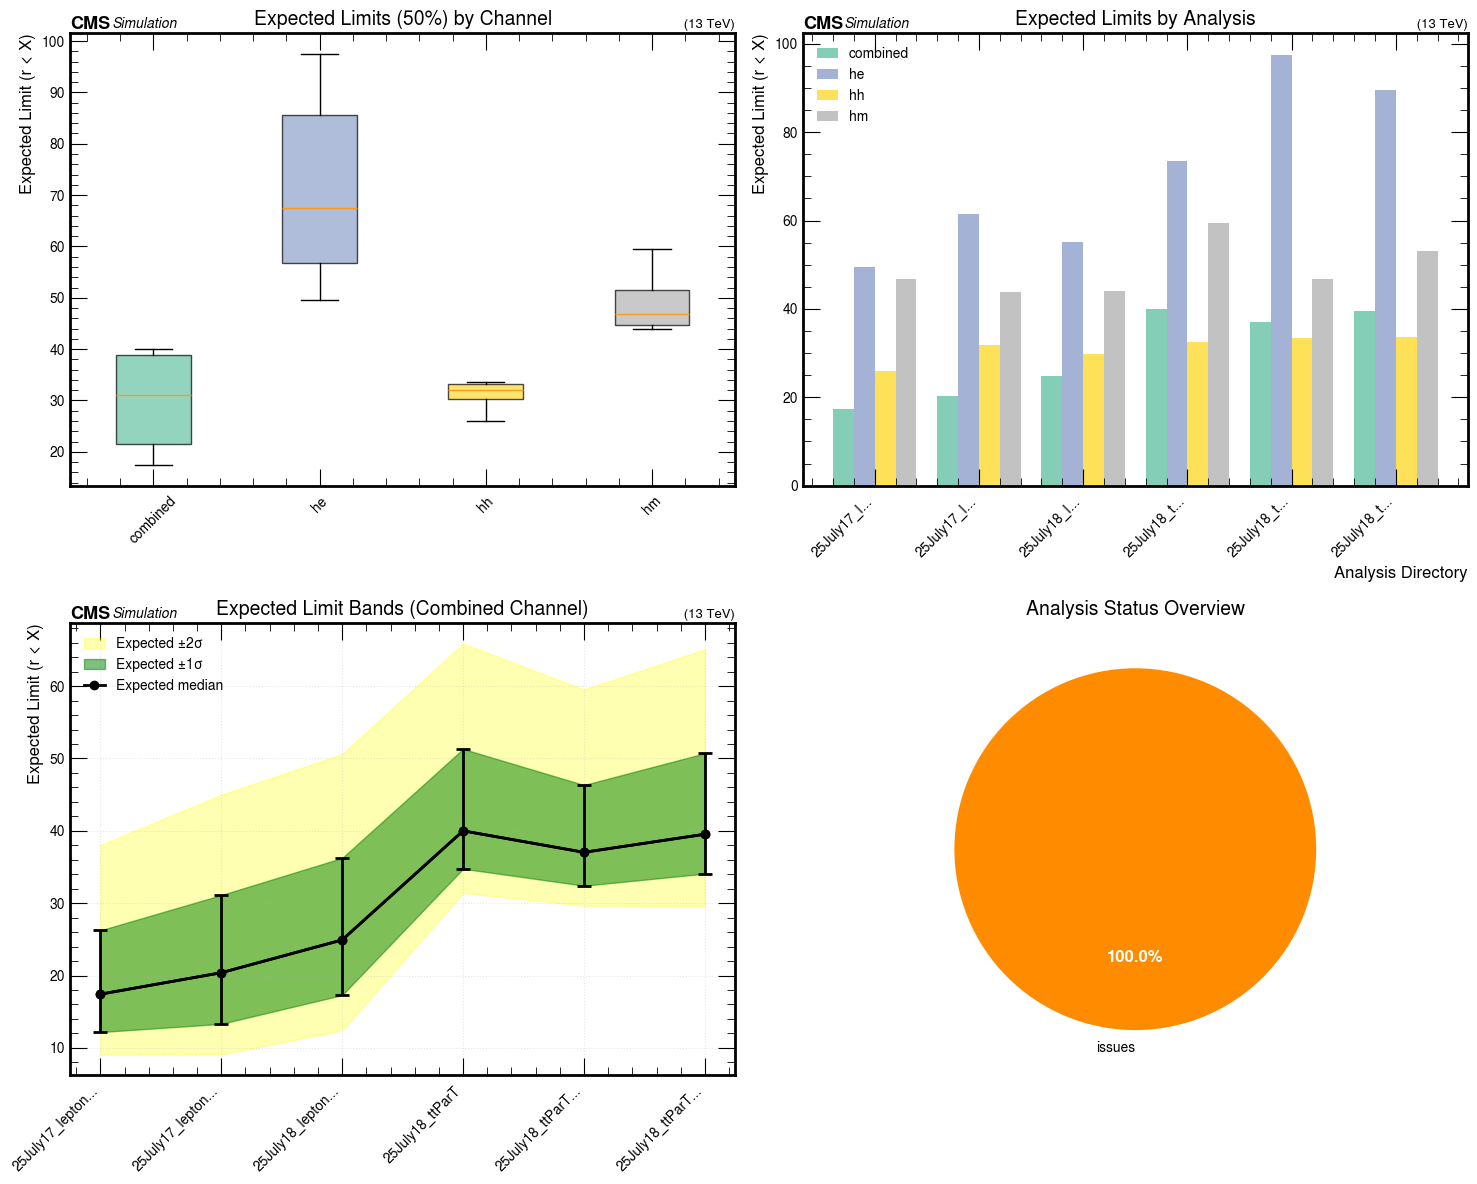

In [7]:
# Plot expected limits comparison
if "expected_50.0" in results_df.columns and len(results_df) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Expected limits by channel
    ax1 = axes[0, 0]
    channel_data = results_df.dropna(subset=["expected_50.0"])
    if len(channel_data) > 0:
        # Create boxplot using matplotlib
        channels = sorted(channel_data["channel"].unique())
        box_data = [
            channel_data[channel_data["channel"] == ch]["expected_50.0"].values for ch in channels
        ]

        bp = ax1.boxplot(box_data, labels=channels, patch_artist=True)
        # Color boxes with CMS-style colors
        colors = plt.cm.Set2(np.linspace(0, 1, len(channels)))
        for patch, color in zip(bp["boxes"], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax1.set_title("Expected Limits (50%) by Channel", fontsize=14)
        ax1.set_ylabel("Expected Limit (r < X)", fontsize=12)
        ax1.tick_params(axis="x", rotation=45)
        hep.cms.label(loc=0, ax=ax1, fontsize=10)

    # 2. Expected limits by card directory
    ax2 = axes[0, 1]
    if len(channel_data) > 0:
        # Only show if we have multiple directories
        if channel_data["card_directory"].nunique() > 1:
            # Create grouped bar plot
            directories = sorted(channel_data["card_directory"].unique())
            channels = sorted(channel_data["channel"].unique())

            x = np.arange(len(directories))
            width = 0.8 / len(channels)
            colors = plt.cm.Set2(np.linspace(0, 1, len(channels)))

            for i, channel in enumerate(channels):
                channel_subset = channel_data[channel_data["channel"] == channel]
                heights = [
                    (
                        channel_subset[channel_subset["card_directory"] == d][
                            "expected_50.0"
                        ].values[0]
                        if len(channel_subset[channel_subset["card_directory"] == d]) > 0
                        else 0
                    )
                    for d in directories
                ]

                ax2.bar(x + i * width, heights, width, label=channel, color=colors[i], alpha=0.8)

            ax2.set_xlabel("Analysis Directory")
            ax2.set_ylabel("Expected Limit (r < X)")
            ax2.set_title("Expected Limits by Analysis", fontsize=14)
            ax2.set_xticks(x + width * (len(channels) - 1) / 2)
            ax2.set_xticklabels(
                [d[:10] + "..." if len(d) > 10 else d for d in directories], rotation=45, ha="right"
            )
            ax2.legend(fontsize=10)
            hep.cms.label(loc=0, ax=ax2, fontsize=10)
        else:
            ax2.text(
                0.5,
                0.5,
                "Single analysis directory",
                ha="center",
                va="center",
                transform=ax2.transAxes,
                fontsize=12,
            )
            ax2.set_title("Expected Limits by Analysis", fontsize=14)

    # 3. Limit bands visualization
    ax3 = axes[1, 0]
    band_cols = ["expected_2.5", "expected_16.0", "expected_50.0", "expected_84.0", "expected_97.5"]
    available_bands = [col for col in band_cols if col in results_df.columns]

    if len(available_bands) >= 3:
        # Show bands for combined channel
        combined_data = results_df[results_df["channel"] == "combined"].dropna(
            subset=available_bands
        )
        if len(combined_data) > 0:
            x_pos = range(len(combined_data))
            labels = [f"{d[:15]}..." if len(d) > 15 else d for d in combined_data["card_directory"]]

            # Plot central value and error bands
            ax3.errorbar(
                x_pos,
                combined_data["expected_50.0"],
                yerr=[
                    combined_data["expected_50.0"]
                    - combined_data.get("expected_16.0", combined_data["expected_50.0"]),
                    combined_data.get("expected_84.0", combined_data["expected_50.0"])
                    - combined_data["expected_50.0"],
                ],
                fmt="o-",
                capsize=5,
                capthick=2,
                color="black",
                linewidth=2,
                markersize=6,
            )

            # Add 2σ band if available
            if "expected_2.5" in combined_data.columns and "expected_97.5" in combined_data.columns:
                ax3.fill_between(
                    x_pos,
                    combined_data["expected_2.5"],
                    combined_data["expected_97.5"],
                    alpha=0.3,
                    color="yellow",
                    label="Expected ±2σ",
                )

            # Add 1σ band if available
            if (
                "expected_16.0" in combined_data.columns
                and "expected_84.0" in combined_data.columns
            ):
                ax3.fill_between(
                    x_pos,
                    combined_data["expected_16.0"],
                    combined_data["expected_84.0"],
                    alpha=0.5,
                    color="green",
                    label="Expected ±1σ",
                )

            ax3.plot(
                x_pos,
                combined_data["expected_50.0"],
                "o-",
                color="black",
                linewidth=2,
                markersize=6,
                label="Expected median",
            )

            ax3.set_xticks(x_pos)
            ax3.set_xticklabels(labels, rotation=45, ha="right")
            ax3.set_title("Expected Limit Bands (Combined Channel)", fontsize=14)
            ax3.set_ylabel("Expected Limit (r < X)", fontsize=12)
            ax3.grid(True, alpha=0.3)
            ax3.legend(fontsize=10)
            hep.cms.label(loc=0, ax=ax3, fontsize=10)

    # 4. Status overview
    ax4 = axes[1, 1]
    if "status" in results_df.columns:
        status_counts = results_df["status"].value_counts()
        colors = [
            "#2E8B57" if s == "success" else "#FF8C00" if s == "issues" else "#DC143C"
            for s in status_counts.index
        ]
        wedges, texts, autotexts = ax4.pie(
            status_counts.values,
            labels=status_counts.index,
            autopct="%1.1f%%",
            colors=colors,
            startangle=90,
        )
        ax4.set_title("Analysis Status Overview", fontsize=14)
        # Make percentage text more readable
        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontweight("bold")

    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for plotting")

In [8]:
# Identify problematic analyses
print("=== ISSUES AND WARNINGS REPORT ===")

# Convergence issues
if "fit_converged" in results_df.columns:
    non_converged = results_df[results_df["fit_converged"] == False]
    if len(non_converged) > 0:
        print(f"\n⚠️  NON-CONVERGED BACKGROUND FITS ({len(non_converged)})")
        for _, row in non_converged.iterrows():
            print(f"  - {row['card_directory']} / {row['channel']}")
    else:
        print("\n✅ All background fits converged")

# Limit calculation issues
if "status" in results_df.columns:
    failed_limits = results_df[results_df["status"] != "success"]
    if len(failed_limits) > 0:
        print(f"\n⚠️  LIMIT CALCULATION ISSUES ({len(failed_limits)})")
        for _, row in failed_limits.iterrows():
            issues = ", ".join(row.get("convergence_issues", []))
            print(f"  - {row['card_directory']} / {row['channel']}: {row['status']} ({issues})")
    else:
        print("\n✅ All limit calculations successful")

# Outlier limits (unusually high or low)
if "expected_50.0" in results_df.columns:
    valid_limits = results_df.dropna(subset=["expected_50.0"])
    if len(valid_limits) > 1:
        Q1 = valid_limits["expected_50.0"].quantile(0.25)
        Q3 = valid_limits["expected_50.0"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = valid_limits[
            (valid_limits["expected_50.0"] < lower_bound)
            | (valid_limits["expected_50.0"] > upper_bound)
        ]

        if len(outliers) > 0:
            print(f"\n📊 OUTLIER LIMITS ({len(outliers)})")
            print(f"   Normal range: {lower_bound:.3f} - {upper_bound:.3f}")
            for _, row in outliers.iterrows():
                print(f"  - {row['card_directory']} / {row['channel']}: {row['expected_50.0']:.3f}")
        else:
            print("\n✅ No outlier limits detected")

# Function call warnings
if "function_calls" in results_df.columns:
    high_calls = results_df[results_df["function_calls"] > 10000]  # Arbitrary threshold
    if len(high_calls) > 0:
        print(f"\n⏱️  HIGH FUNCTION CALL COUNT ({len(high_calls)})")
        for _, row in high_calls.iterrows():
            print(f"  - {row['card_directory']} / {row['channel']}: {row['function_calls']} calls")

print("\n=== END REPORT ===")

=== ISSUES AND WARNINGS REPORT ===

✅ All background fits converged

⚠️  LIMIT CALCULATION ISSUES (24)
  - 25July17_leptonBDT / combined: issues (errors_present, warnings_present)
  - 25July17_leptonBDT / hh: issues (errors_present, warnings_present)
  - 25July17_leptonBDT / he: issues (errors_present, warnings_present)
  - 25July17_leptonBDT / hm: issues (errors_present, warnings_present)
  - 25July17_leptonBDT_bmin5 / combined: issues (errors_present, warnings_present)
  - 25July17_leptonBDT_bmin5 / hh: issues (errors_present, warnings_present)
  - 25July17_leptonBDT_bmin5 / he: issues (errors_present, warnings_present)
  - 25July17_leptonBDT_bmin5 / hm: issues (errors_present, warnings_present)
  - 25July18_leptonBDT_bmin8 / combined: issues (errors_present, warnings_present)
  - 25July18_leptonBDT_bmin8 / hh: issues (errors_present, warnings_present)
  - 25July18_leptonBDT_bmin8 / he: issues (errors_present, warnings_present)
  - 25July18_leptonBDT_bmin8 / hm: issues (errors_presen

In [ ]:
# Save results to CSV for further analysis
output_file = Path(CARDS_BASE_DIR) / "analysis_results_summary.csv"
results_df.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

# Create a summary report
report_file = Path(CARDS_BASE_DIR) / "analysis_report.txt"
with open(report_file, "w") as f:
    f.write("HiggsCombine Analysis Report\n")
    f.write("=" * 30 + "\n\n")

    f.write(f"Generated: {pd.Timestamp.now()}\n\n")

    f.write("SUMMARY:\n")
    f.write(f"- Total analyses: {len(results_df)}\n")
    f.write(f"- Card directories: {results_df['card_directory'].nunique()}\n")
    f.write(f"- Channels: {', '.join(sorted(results_df['channel'].unique()))}\n\n")

    if "expected_50.0" in results_df.columns:
        combined_limits = results_df[results_df["channel"] == "combined"]["expected_50.0"].dropna()
        if len(combined_limits) > 0:
            f.write("COMBINED CHANNEL EXPECTED LIMITS:\n")
            f.write(f"- Best limit: {combined_limits.min():.3f}\n")
            f.write(f"- Median limit: {combined_limits.median():.3f}\n")
            f.write(f"- Worst limit: {combined_limits.max():.3f}\n\n")

    if "fit_converged" in results_df.columns:
        conv_rate = results_df["fit_converged"].sum() / len(results_df) * 100
        f.write(f"CONVERGENCE RATE: {conv_rate:.1f}%\n\n")

    f.write("DETAILED RESULTS: See analysis_results_summary.csv\n")

print(f"Summary report saved to: {report_file}")
print("\n📁 Output files created:")
print(f"  - {output_file.name}")
print(f"  - {report_file.name}")